In [9]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
ROOT_DIR_PATH = os.environ.get('ROOT_PATH')
sys.path.append(os.path.abspath(ROOT_DIR_PATH)) 
import urllib.request
import zipfile
import shutil

DESTINATION_PATH =f'{ROOT_DIR_PATH}/data/TINYIMAGENET/'
ZIP_NAME = 'tiny-imagenet-200.zip'


def download_tiny_imagenet(save_path=f'{DESTINATION_PATH}{ZIP_NAME}'):
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    print(f"Downloading TinyImageNet to {save_path}...")
    urllib.request.urlretrieve(url, save_path)
    print("Download complete!")

def extract_dataset(zip_path=f'{DESTINATION_PATH}{ZIP_NAME}', extract_to=DESTINATION_PATH):
    print(f"Extracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete!")

def rearrange_val_folder(base_dir=f'{DESTINATION_PATH}tiny-imagenet-200/val'):
    print(f"Reorganizing validation folder at {base_dir}...")
    img_dir = os.path.join(base_dir, 'images')
    ann_file = os.path.join(base_dir, 'val_annotations.txt')

    with open(ann_file, 'r') as f:
        for line in f:
            file_name, class_name = line.split('\t')[:2]
            class_dir = os.path.join(base_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            src = os.path.join(img_dir, file_name)
            dst = os.path.join(class_dir, file_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    shutil.rmtree(img_dir)
    print("Validation images reorganized!")

def main():
    dst_dir = DESTINATION_PATH
    zip_fname = f"{DESTINATION_PATH}{ZIP_NAME}"

    if not os.path.isdir(dst_dir):
        print('creating the destination dir. & downloading')
        os.makedirs(os.path.dirname(dst_dir), exist_ok=True)
        download_tiny_imagenet(zip_fname)
        extract_dataset(zip_path=zip_fname, extract_to=os.path.dirname(dst_dir))
        rearrange_val_folder(base_dir=f'{DESTINATION_PATH}tiny-imagenet-200/val')
        print(f"TinyImageNet is ready under: {dst_dir}/")
    else:
        print(f"Dataset directory {dst_dir} already exists, zip downloaded.")

    if not os.path.isdir(f'{DESTINATION_PATH}tiny-imagenet-200/'):
        extract_dataset(zip_path=zip_fname, extract_to=os.path.dirname(dst_dir))
        rearrange_val_folder(base_dir=f'{DESTINATION_PATH}tiny-imagenet-200/val')
        print(f"TinyImageNet is ready under: {dst_dir}")
    else : print(f'TinyImageNet already exists under: {dst_dir}')


if __name__ == '__main__':
    main()

Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/


In [4]:
dst_dir = DESTINATION_PATH
zip_fname = f"{DESTINATION_PATH}{ZIP_NAME}"

In [6]:
def main():
    # You can customize this path
    dst_dir = DESTINATION_PATH
    zip_fname = f"{DESTINATION_PATH}{ZIP_NAME}"

    if not os.path.isdir(dst_dir):
        print('creating the destination dir. & downloading')
        os.makedirs(os.path.dirname(dst_dir), exist_ok=True)
        download_tiny_imagenet(zip_fname)
        extract_dataset(zip_path=zip_fname, extract_to=os.path.dirname(dst_dir))
        
        print(f"TinyImageNet is ready under: {dst_dir}/")
    else:
        print(f"Dataset directory {dst_dir}/ already exists. Skipping download.")

if __name__ == '__main__':
    main()


creating the destination dir. & downloading


KeyboardInterrupt: 

In [ ]:
def rearrange_val_folder(base_dir=f'{EXTRACT_PATH}/tiny-imagenet-200/val'):
    print(f"Reorganizing validation folder at {base_dir}...")
    img_dir = os.path.join(base_dir, 'images')
    ann_file = os.path.join(base_dir, 'val_annotations.txt')

    with open(ann_file, 'r') as f:
        for line in f:
            file_name, class_name = line.split('\t')[:2]
            class_dir = os.path.join(base_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            src = os.path.join(img_dir, file_name)
            dst = os.path.join(class_dir, file_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    shutil.rmtree(img_dir)
    print("Validation images reorganized!")

# training test

In [11]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
ROOT_DIR_PATH = os.environ.get('ROOT_PATH')
sys.path.append(os.path.abspath(ROOT_DIR_PATH))  # Adds root directory to sys.path

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from model.vit import VisionTransformerSmall
from utils.model_io import save_model
from utils.config_loader import load_config
from utils.data_loader import DatasetLoader
from pynvml import (
    nvmlInit, nvmlDeviceGetName, nvmlShutdown,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetUtilizationRates
)
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm.data import Mixup
import numpy as np
from transformers import get_cosine_schedule_with_warmup

def train_one_epoch(model, loader, criterion, optimizer, device, 
                    mixup_fn=None, scheduler_warmup_enabled=False, scheduler_warmup=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training", leave=True)
    for  inputs, targets in progress_bar:
        #print(f'input shape : {inputs.shape}, taget_shape : {targets.shape}, target dim : {targets.ndim}')
        inputs, targets = inputs.to(device), targets.to(device)
        if mixup_fn is not None:
            inputs, targets = mixup_fn(inputs, targets)

        if targets.ndim == 2:
            targets = targets.type_as(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler_warmup_enabled:
            if scheduler_warmup is None : raise Exception(f'scheduler warmup is enabled, but no scheduler object has been passed in train_one_epoch function')
            scheduler_warmup.step()

        running_loss += loss.item() * inputs.size(0)

        if targets.ndim == 2:
            # MixUp with soft labels
            _, predicted = outputs.max(1)
            _, true_classes = targets.max(1)  # Take argmax of soft labels as true class
            correct += predicted.eq(true_classes).sum().item()
            total += targets.size(0)
        else :
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

        # Update progress bar with metrics
        if total > 0:
            avg_loss = running_loss / total
            accuracy = 100. * correct / total
            progress_bar.set_postfix({
                "Loss": f"{avg_loss:.4f}",
                "Acc": f"{accuracy:.2f}%"
            })

        else : raise Exception(f'Expected non-zero batch size, but got 0 targets. Check if the dataset is empty or DataLoader is misconfigured.')

    
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(loader, desc="Validation", leave=True)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            # Avoid division by zero on first step
            if total > 0:
                avg_loss = running_loss / total
                accuracy = 100. * correct / total

                progress_bar.set_postfix({
                    "Loss": f"{avg_loss:.4f}",
                    "Acc": f"{accuracy:.2f}%"
                })
                
    return avg_loss, accuracy



/home/wd/Documents/work_stuff/ViT_REPLICATION/_vit_rep_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# def main():
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load config
config = load_config(f"{ROOT_DIR_PATH}/config/vit_config.yaml")
# loading cifar100
#cifar100_config = config["data"]['CIFAR100']
dataset_config = config["data"]['TINYIMAGENET']
DATASET = dataset_config["dataset"]
DATA_DIR = dataset_config["data_path"]
BATCH = dataset_config["batch_size"]
NUM_WORKERS = dataset_config["num_workers"]
IMAGE = dataset_config["img_size"]
NUM_CLASSES = dataset_config["num_classes"]
CHANNELS = dataset_config["channels"]

Using device: cuda


In [18]:
# loading data
print(f'loading dataset : {DATASET}')
loader = DatasetLoader(dataset_name=DATASET,
                        data_dir=DATA_DIR,
                        batch_size=BATCH,
                        num_workers=NUM_WORKERS,
                        img_size=IMAGE)
train_loader, val_loader = loader.get_loaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
print('data sanity check')
for images, labels in train_loader:
    print(f'image shape and labels shape in training data - one batch : {images.shape}, {labels.shape}')
    break

loading dataset : TINYIMAGENET
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/
training size  : 50000
validation size : 10000
Classes: 200
Sample label: 75
Train batches: 391, Validation batches: 79
data sanity check
image shape and labels shape in training data - one batch : torch.Size([128, 3, 64, 64]), torch.Size([128])


# debug

In [4]:
# def main():
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load config
config = load_config(f"{ROOT_DIR_PATH}/config/vit_config.yaml")
# loading cifar100
#cifar100_config = config["data"]['CIFAR100']
dataset_config = config["data"]['TINYIMAGENET']
DATASET = dataset_config["dataset"]
DATA_DIR = dataset_config["data_path"]
BATCH = dataset_config["batch_size"]
NUM_WORKERS = dataset_config["num_workers"]
IMAGE = dataset_config["img_size"]
NUM_CLASSES = dataset_config["num_classes"]
CHANNELS = dataset_config["channels"]

# loading data
print(f'loading dataset : {DATASET}')
loader = DatasetLoader(dataset_name=DATASET,
                        data_dir=DATA_DIR,
                        batch_size=BATCH,
                        num_workers=NUM_WORKERS,
                        img_size=IMAGE)
train_loader, val_loader = loader.get_loaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
print('data sanity check')
for images, labels in train_loader:
    print(f'image shape and labels shape in training data - one batch : {images.shape}, {labels.shape}')
    break

Using device: cuda
loading dataset : TINYIMAGENET
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/
training size  : 50000
validation size : 10000
Classes: 200
Sample label: 62
Train batches: 391, Validation batches: 79
data sanity check
image shape and labels shape in training data - one batch : torch.Size([128, 3, 64, 64]), torch.Size([128])


In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
ROOT_DIR_PATH = os.environ.get('ROOT_PATH')
sys.path.append(os.path.abspath(ROOT_DIR_PATH))  # Adds root directory to sys.path

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from model.vit import VisionTransformerSmall
from utils.model_io import save_model
from utils.config_loader import load_config
from utils.data_loader import DatasetLoader
from pynvml import (
    nvmlInit, nvmlDeviceGetName, nvmlShutdown,
    nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetMemoryInfo,
    nvmlDeviceGetUtilizationRates
)
from torch.optim.lr_scheduler import CosineAnnealingLR
from timm.data import Mixup
import numpy as np
from transformers import get_cosine_schedule_with_warmup

/home/wd/Documents/work_stuff/ViT_REPLICATION/_vit_rep_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


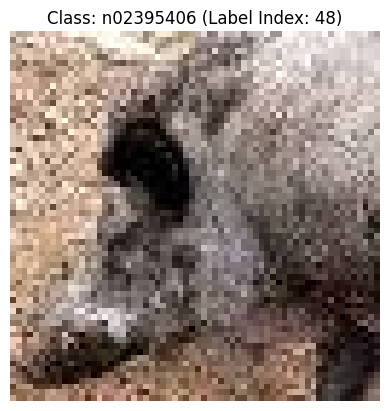

In [2]:
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load ROOT_PATH from .env
load_dotenv()
ROOT_DIR = os.environ.get("ROOT_PATH")
DATA_DIR = os.path.join(ROOT_DIR, "data", "TINYIMAGENET")

# Define clean (deterministic) transform
clean_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust to your ViT input size
    transforms.ToTensor()
])

# Recreate the clean version of the dataset
clean_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "tiny-imagenet-200", "train"),
    transform=clean_transform
)

# Pick a fixed index
index = 24234
img, label = clean_dataset[index]

# Visualize the image
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {clean_dataset.classes[label]} (Label Index: {label})")
plt.axis('off')
plt.show()


In [5]:
IMAGE

64

In [14]:

config = load_config(f"{ROOT_DIR_PATH}/config/vit_config.yaml")
modelConfig = config["model"]
specific_config = modelConfig['VIT_SMALL']
MODEL_NAME = specific_config["name"]
modelConfigDict = {
    'CHANNEL' : CHANNELS,
    'PATCH' : specific_config['patch_size'],
    'EMBEDDING' : specific_config['emb_size'],
    'IMAGE' : IMAGE,
    'NUM_HEADS' : specific_config['num_heads'],
    'MLP_RATIO' : specific_config['mlp_ratio'],
    'DROPOUT' : specific_config['dropout'],
    'NUM_CLASSES' : NUM_CLASSES,
    'DEPTH' : specific_config['depth']
}    
# 4. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print(f"Using device: {device}")

#model = VisionTransformerSmall(**modelConfigDict).to(device)

# tryin with different model
import torchvision.models as models
model = models.resnet18(pretrained=True)
# Replace classifier head to match TinyImageNet classes (200)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

model.eval()

simple_transform = transforms.Compose([
    #transforms.Resize((IMAGE, IMAGE)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(dataset_config['mean_aug'], dataset_config['std_aug'])
])
# 7. Load clean dataset (few samples)
dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "tiny-imagenet-200", "train"),
    transform=simple_transform
)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

# 8. Run model on a small batch
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    loss = criterion(outputs, labels)
    preds = outputs.argmax(dim=1)

# 9. Print outputs
print(f"Loss: {loss.item():.4f}")
print("Predicted label distribution:", torch.bincount(preds))
print("True label distribution     :", torch.bincount(labels))

Using device: cuda
Loss: 5.3892
Predicted label distribution: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       device='cuda:0')
True label distribution     : tensor([8], device='cuda:0')


In [42]:
images.min()

tensor(-2.1179, device='cuda:0')

In [44]:
dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "tiny-imagenet-200", "train"))
print(f"Number of classes: {len(dataset.classes)}")
print("Sample class names:", dataset.classes[:5])

Number of classes: 200
Sample class names: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']


In [45]:
from collections import Counter
labels = [label for _, label in dataset]
print(Counter(labels))

Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 500, 16: 500, 17: 500, 18: 500, 19: 500, 20: 500, 21: 500, 22: 500, 23: 500, 24: 500, 25: 500, 26: 500, 27: 500, 28: 500, 29: 500, 30: 500, 31: 500, 32: 500, 33: 500, 34: 500, 35: 500, 36: 500, 37: 500, 38: 500, 39: 500, 40: 500, 41: 500, 42: 500, 43: 500, 44: 500, 45: 500, 46: 500, 47: 500, 48: 500, 49: 500, 50: 500, 51: 500, 52: 500, 53: 500, 54: 500, 55: 500, 56: 500, 57: 500, 58: 500, 59: 500, 60: 500, 61: 500, 62: 500, 63: 500, 64: 500, 65: 500, 66: 500, 67: 500, 68: 500, 69: 500, 70: 500, 71: 500, 72: 500, 73: 500, 74: 500, 75: 500, 76: 500, 77: 500, 78: 500, 79: 500, 80: 500, 81: 500, 82: 500, 83: 500, 84: 500, 85: 500, 86: 500, 87: 500, 88: 500, 89: 500, 90: 500, 91: 500, 92: 500, 93: 500, 94: 500, 95: 500, 96: 500, 97: 500, 98: 500, 99: 500, 100: 500, 101: 500, 102: 500, 103: 500, 104: 500, 105: 500, 106: 500, 107: 500, 108: 500, 109: 500, 1

In [46]:
import os
from glob import glob

train_dir = os.path.join(DATA_DIR, "tiny-imagenet-200", "train")
class_folders = os.listdir(train_dir)
print(f"Total class folders: {len(class_folders)}")
print("Sample folders:", class_folders[:5])

# Check sample image path inside first class
sample_images = glob(os.path.join(train_dir, class_folders[0], "images", "*.JPEG"))
print(f"Sample image file from class {class_folders[0]}:")
print(sample_images[0] if sample_images else "No image found")


Total class folders: 200
Sample folders: ['n01917289', 'n02132136', 'n01983481', 'n01774384', 'n03804744']
Sample image file from class n01917289:
No image found


In [48]:
import os

def count_folders_and_files(root_dir):
    class_folders = [d for d in os.listdir(root_dir)
                     if os.path.isdir(os.path.join(root_dir, d))]
    
    total_classes = len(class_folders)
    total_images = 0

    for class_folder in class_folders:
        class_path = os.path.join(root_dir, class_folder)
        image_files = [f for f in os.listdir(class_path)
                       if os.path.isfile(os.path.join(class_path, f)) and f.endswith('.JPEG')]
        total_images += len(image_files)
    
    print(f"Path: {root_dir}")
    print(f"🗂️  Total class folders: {total_classes}")
    print(f"🖼️  Total image files:  {total_images}")
    print("-" * 40)
    return total_classes, total_images


# 🔍 Run this to verify structure:
train_path = '/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/tiny-imagenet-200/train'
val_path = '/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/tiny-imagenet-200/val'

count_folders_and_files(train_path)
count_folders_and_files(val_path)


Path: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/tiny-imagenet-200/train
🗂️  Total class folders: 200
🖼️  Total image files:  100000
----------------------------------------
Path: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET/tiny-imagenet-200/val
🗂️  Total class folders: 200
🖼️  Total image files:  10000
----------------------------------------


(200, 10000)

### 2 Layer CNN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ---------- Configuration ----------
DATA_PATH = "/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/tiny-imagenet-200/train" 
BATCH_SIZE = 32
NUM_CLASSES = 20
SAMPLES_PER_CLASS = 5
EPOCHS = 25
LR = 0.001
IMG_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Basic Transform (no aug) ----------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # TinyImageNet stats
                         std=[0.229, 0.224, 0.225]),
])

# ---------- Dataset and Balanced Subset ----------
dataset = datasets.ImageFolder(DATA_PATH, transform=transform)

# Build class-balanced index list
class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset):
    class_to_indices[label].append(idx)

subset_indices = []
for label in sorted(class_to_indices.keys())[:NUM_CLASSES]:
    subset_indices.extend(class_to_indices[label][:SAMPLES_PER_CLASS])

subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ---------- Simple 2-Layer CNN ----------
class TwoLayerCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B, 32, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 64, 16, 16)
            nn.Flatten(),  # (B, 64*16*16)
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ---------- Training Setup ----------
model = TwoLayerCNN(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ---------- Training Loop ----------
for epoch in range(EPOCHS):
    model.train()
    total_correct = 0
    total_samples = 0
    running_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(1)
        total_correct += preds.eq(labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item() * labels.size(0)

    acc = total_correct / total_samples * 100
    avg_loss = running_loss / total_samples
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f}, Train Acc: {acc:.2f}%")

print("\nOverfit test complete.")


Epoch [1/25] Loss: 3.5236, Train Acc: 5.00%
Epoch [2/25] Loss: 2.8097, Train Acc: 14.00%
Epoch [3/25] Loss: 2.6212, Train Acc: 29.00%
Epoch [4/25] Loss: 2.2390, Train Acc: 37.00%
Epoch [5/25] Loss: 1.6952, Train Acc: 54.00%
Epoch [6/25] Loss: 1.1649, Train Acc: 66.00%
Epoch [7/25] Loss: 0.8610, Train Acc: 71.00%
Epoch [8/25] Loss: 0.4986, Train Acc: 88.00%
Epoch [9/25] Loss: 0.3869, Train Acc: 93.00%
Epoch [10/25] Loss: 0.1977, Train Acc: 98.00%
Epoch [11/25] Loss: 0.0854, Train Acc: 100.00%
Epoch [12/25] Loss: 0.0496, Train Acc: 99.00%
Epoch [13/25] Loss: 0.0229, Train Acc: 100.00%
Epoch [14/25] Loss: 0.0283, Train Acc: 99.00%
Epoch [15/25] Loss: 0.0086, Train Acc: 100.00%
Epoch [16/25] Loss: 0.0057, Train Acc: 100.00%
Epoch [17/25] Loss: 0.0034, Train Acc: 100.00%
Epoch [18/25] Loss: 0.0025, Train Acc: 100.00%
Epoch [19/25] Loss: 0.0022, Train Acc: 100.00%
Epoch [20/25] Loss: 0.0017, Train Acc: 100.00%
Epoch [21/25] Loss: 0.0013, Train Acc: 100.00%
Epoch [22/25] Loss: 0.0011, Train A

### ViT - timm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from timm.models.vision_transformer import vit_tiny_patch16_224
import os
import gc
from collections import defaultdict

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

# ========== Config ==========
DATA_DIR = "/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
NUM_CLASSES = 20
BATCH_SIZE = 100  # for 100 samples
LR = 3e-4

# ========== Transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== Load Dataset ==========
train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)

# Build class-balanced 100-sample subset: 20 classes × 5 samples
class_to_idx = defaultdict(list)
for idx, (_, label) in enumerate(train_data):
    class_to_idx[label].append(idx)

subset_indices = []
for label in sorted(class_to_idx.keys())[:20]:  # 20 classes
    subset_indices.extend(class_to_idx[label][:5])  # 5 samples each

subset = Subset(train_data, subset_indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# ========== Model ==========
model = vit_tiny_patch16_224(pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)

# ========== Loss & Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)  # No weight decay

# ========== Train Loop ==========
for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Epoch {epoch+1:02d} | Train Acc: {acc:.2f}%")

    # stop early if we hit 100% train acc
    if acc == 100.0:
        print("Model has successfully overfitted the subset.")
        break


/home/wd/Documents/work_stuff/ViT_REPLICATION/_vit_rep_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 01 | Train Acc: 5.00%
Epoch 02 | Train Acc: 18.00%
Epoch 03 | Train Acc: 26.00%
Epoch 04 | Train Acc: 30.00%
Epoch 05 | Train Acc: 29.00%
Epoch 06 | Train Acc: 37.00%
Epoch 07 | Train Acc: 37.00%
Epoch 08 | Train Acc: 38.00%
Epoch 09 | Train Acc: 41.00%
Epoch 10 | Train Acc: 47.00%
Epoch 11 | Train Acc: 54.00%
Epoch 12 | Train Acc: 57.00%
Epoch 13 | Train Acc: 58.00%
Epoch 14 | Train Acc: 63.00%
Epoch 15 | Train Acc: 62.00%
Epoch 16 | Train Acc: 61.00%
Epoch 17 | Train Acc: 71.00%
Epoch 18 | Train Acc: 71.00%
Epoch 19 | Train Acc: 78.00%
Epoch 20 | Train Acc: 75.00%
Epoch 21 | Train Acc: 74.00%
Epoch 22 | Train Acc: 79.00%
Epoch 23 | Train Acc: 79.00%
Epoch 24 | Train Acc: 83.00%
Epoch 25 | Train Acc: 86.00%
Epoch 26 | Train Acc: 87.00%
Epoch 27 | Train Acc: 89.00%
Epoch 28 | Train Acc: 91.00%
Epoch 29 | Train Acc: 92.00%
Epoch 30 | Train Acc: 92.00%
Epoch 31 | Train Acc: 96.00%
Epoch 32 | Train Acc: 97.00%
Epoch 33 | Train Acc: 99.00%
Epoch 34 | Train Acc: 97.00%
Epoch 35 | Trai

### ViT - own

In [3]:
# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size, img_size):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)        # (B, emb_size, H/patch, W/patch)
        x = x.flatten(2)              # (B, emb_size, N)
        x = x.transpose(1, 2)         # (B, N, emb_size)
        return x                      # Shape: (B, N, E)

# Transformer Encoder Block - replicating the original Paper (Vaswani, 2017)
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_ratio, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.mlp(self.ln2(x))
        return x
    
class VisionTransformerSmall(nn.Module):
    def __init__(self, 
                 CHANNEL, PATCH, EMBEDDING, IMAGE, NUM_HEADS, MLP_RATIO, DROPOUT, NUM_CLASSES, DEPTH
                 ):
        super().__init__()
        
        self.CHANNEL = CHANNEL
        self.PATCH = PATCH
        self.EMBEDDING = EMBEDDING
        self.IMAGE = IMAGE
        self.NUM_HEADS = NUM_HEADS
        self.MLP_RATIO = MLP_RATIO
        self.DROPOUT = DROPOUT
        self.NUM_CLASS = NUM_CLASSES
        self.DEPTH = DEPTH

        self.patch_embed = PatchEmbedding(
            in_channels=self.CHANNEL,
            patch_size=self.PATCH,
            emb_size=self.EMBEDDING,
            img_size=self.IMAGE
        )

        self.n_patches = (self.IMAGE// self.PATCH) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.EMBEDDING))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, self.EMBEDDING))

        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                emb_size=self.EMBEDDING,
                num_heads=self.NUM_HEADS,
                mlp_ratio=self.MLP_RATIO,
                dropout=self.DROPOUT
            ) for _ in range(self.DEPTH)
        ])

        self.norm = nn.LayerNorm(self.EMBEDDING)
        self.head = nn.Linear(self.EMBEDDING, self.NUM_CLASS)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        cls_out = self.norm(x[:, 0])
        return self.head(cls_out)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from timm.models.vision_transformer import vit_tiny_patch16_224
import os
from collections import defaultdict
import gc
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

# ========== Config ==========
DATA_DIR = "/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
NUM_CLASSES = 20
BATCH_SIZE = 16  # for 100 samples
LR = 3e-4

modelConfigDict = {
    'CHANNEL' : 3,
    'PATCH' : 16,
    'EMBEDDING' : 192,
    'IMAGE' : 224,
    'NUM_HEADS' : 3,
    'MLP_RATIO' : 4.0,
    'DROPOUT' : 0.0,
    'NUM_CLASSES' : 20,
    'DEPTH' : 12
}    


# ========== Transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== Load Dataset ==========
train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)

# Build class-balanced 100-sample subset: 20 classes × 5 samples
class_to_idx = defaultdict(list)
for idx, (_, label) in enumerate(train_data):
    class_to_idx[label].append(idx)

subset_indices = []
for label in sorted(class_to_idx.keys())[:20]:  # 20 classes
    subset_indices.extend(class_to_idx[label][:5])  # 5 samples each

subset = Subset(train_data, subset_indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# ========== Model ==========
model = VisionTransformerSmall(**modelConfigDict).to(DEVICE)

# ========== Loss & Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)  # No weight decay

# ========== Train Loop ==========
for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Epoch {epoch+1:02d} | Train Acc: {acc:.2f}%")

    # stop early if we hit 100% train acc
    if acc == 100.0:
        print("Model has successfully overfitted the subset.")
        break


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.69 GiB of which 3.31 MiB is free. Including non-PyTorch memory, this process has 3.67 GiB memory in use. Of the allocated memory 3.32 GiB is allocated by PyTorch, and 252.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Creating another version

#### V01

In [ ]:
import torch
import torch.nn as nn

# Patch Embedding
class PatchEmbedding(nn.Module):
    
    def __init__(self, img_size, patch_size, embed_dim, in_channels=3):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2

        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )  # [B, C, H, W] -> [B, embed_dim, H//P, W//P]
 
    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)  # -> [B, embed_dim, H//P, W//P]
        x = x.flatten(2).transpose(1, 2)  # -> [B, num_patches, embed_dim]
        return x

In [3]:
class Attention(nn.Module):

    def __init__(self, dim, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert dim % num_heads == 0, "Embedding dim must be divisible by number of heads"

        self.scale = self.head_dim ** -0.5  # Scaling factor: 1/sqrt(dk)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)  # Fused Q, K, V
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)  # Final projection
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):

        B, N, C = x.shape

        # Step 1: Linear layer to get Q, K, V
        qkv = self.qkv(x)                      # [B, N, 3*C]
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)       # [3, B, num_heads, N, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]       # [B, num_heads, N, head_dim]

        # Step 2: Compute scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # [B, heads, N, N]
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Step 3: Weighted sum of values
        out = (attn @ v)  # [B, heads, N, head_dim]
        out = out.transpose(1, 2).reshape(B, N, C)  # [B, N, C]
        out = self.proj(out)
        out = self.proj_drop(out)

        return out


In [4]:
import torch
import torch.nn as nn

class DropPath(nn.Module):
    """Stochastic Depth (DropPath) as per https://arxiv.org/abs/1603.09382"""
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def drop_path_method(self, x, drop_prob: float = 0., training: bool = False):
        if drop_prob == 0. or not training:
            return x
        keep_prob = 1 - drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # (B, 1, 1, ...)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output

    def forward(self, x):
        return self.drop_path_method(x, self.drop_prob, self.training)




In [10]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_ratio, dropout, drop_path_rate=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = Attention(dim=emb_size, num_heads=num_heads)
        self.drop_path1 = DropPath(drop_path_rate)

        self.ln2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout)
        )
        self.drop_path2 = DropPath(drop_path_rate)

    def forward(self, x):
        x = x + self.drop_path1(self.attn(self.ln1(x)))  # Apply drop-path to attention output
        x = x + self.drop_path2(self.mlp(self.ln2(x)))   # Apply drop-path to MLP output
        return x


In [11]:
# Transformer Block (basic)
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_ratio):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.mlp(self.ln2(x))
        return x

# Mini ViT
class MiniViT(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_channels=3, num_classes=200,
                 emb_size=384, depth=4, num_heads=6, mlp_ratio=3.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_size))

        self.transformer = nn.Sequential(*[
            TransformerBlock(emb_size, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.norm(x[:, 0])
        return self.head(x)


class VisionTransformerTiny(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_channels=3,
                 num_classes=20,
                 embed_dim=192,
                 depth=12,
                 num_heads=3,
                 mlp_ratio=4.0,
                 qkv_bias=True,
                 drop_rate=0.0,
                 attn_drop_rate=0.0,
                 drop_path_rate=0.1):

        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        # Class token and positional embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks with gradually increasing drop_path
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(
                emb_size=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=drop_rate,
                drop_path_rate=dpr[i]
            )
            for i in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.constant_(self.head.bias, 0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, C)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, C)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, C)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]  # CLS token output

    def forward(self, x):
        x = self.forward_features(x)
        return self.head(x)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from timm.models.vision_transformer import vit_tiny_patch16_224
import os
from collections import defaultdict
import gc
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

# ========== Config ==========
DATA_DIR = "/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
NUM_CLASSES = 20
BATCH_SIZE = 16  # for 100 samples
LR = 3e-4

modelConfigDict = {
    'CHANNEL' : 3,
    'PATCH' : 16,
    'EMBEDDING' : 192,
    'IMAGE' : 224,
    'NUM_HEADS' : 3,
    'MLP_RATIO' : 4.0,
    'DROPOUT' : 0.0,
    'NUM_CLASSES' : 20,
    'DEPTH' : 12
}    


# ========== Transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ========== Load Dataset ==========
train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)

# Build class-balanced 100-sample subset: 20 classes × 5 samples
class_to_idx = defaultdict(list)
for idx, (_, label) in enumerate(train_data):
    class_to_idx[label].append(idx)

subset_indices = []
for label in sorted(class_to_idx.keys())[:20]:  # 20 classes
    subset_indices.extend(class_to_idx[label][:5])  # 5 samples each

subset = Subset(train_data, subset_indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# ========== Model ==========
#model = VisionTransformerSmall(**modelConfigDict).to(DEVICE)
model = VisionTransformerTiny().to(DEVICE)

# ========== Loss & Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)  # No weight decay

# ========== Train Loop ==========
for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Epoch {epoch+1:02d} | Train Acc: {acc:.2f}%")

    # stop early if we hit 100% train acc
    if acc == 100.0:
        print("Model has successfully overfitted the subset.")
        break


Epoch 01 | Train Acc: 6.00%
Epoch 02 | Train Acc: 14.00%
Epoch 03 | Train Acc: 20.00%
Epoch 04 | Train Acc: 19.00%
Epoch 05 | Train Acc: 26.00%
Epoch 06 | Train Acc: 29.00%
Epoch 07 | Train Acc: 30.00%
Epoch 08 | Train Acc: 32.00%
Epoch 09 | Train Acc: 40.00%
Epoch 10 | Train Acc: 43.00%
Epoch 11 | Train Acc: 45.00%
Epoch 12 | Train Acc: 49.00%
Epoch 13 | Train Acc: 47.00%
Epoch 14 | Train Acc: 51.00%
Epoch 15 | Train Acc: 55.00%
Epoch 16 | Train Acc: 62.00%
Epoch 17 | Train Acc: 66.00%
Epoch 18 | Train Acc: 69.00%
Epoch 19 | Train Acc: 69.00%
Epoch 20 | Train Acc: 74.00%
Epoch 21 | Train Acc: 76.00%
Epoch 22 | Train Acc: 80.00%
Epoch 23 | Train Acc: 89.00%
Epoch 24 | Train Acc: 92.00%
Epoch 25 | Train Acc: 95.00%
Epoch 26 | Train Acc: 98.00%
Epoch 27 | Train Acc: 97.00%
Epoch 28 | Train Acc: 100.00%
Model has successfully overfitted the subset.


In [13]:
ROOT_DIR_PATH

NameError: name 'ROOT_DIR_PATH' is not defined

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from timm.models.vision_transformer import vit_tiny_patch16_224
import os
from collections import defaultdict
import gc
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

# ========== Config ==========
DATA_DIR = "/home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
NUM_CLASSES = 20
BATCH_SIZE = 16  # for 100 samples
LR = 3e-4

# # ========== Transforms ==========
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# # ========== Load Dataset ==========
# train_data = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
import sys
import os
from dotenv import load_dotenv
from utils.data_loader import DatasetLoader
load_dotenv()
ROOT_DIR_PATH = os.environ.get('ROOT_PATH')
sys.path.append(os.path.abspath(ROOT_DIR_PATH))  # Adds root directory to sys.path

from utils.config_loader import load_config
config = load_config(f"{ROOT_DIR_PATH}/config/vit_config.yaml")
trainingConfig = config['training_dummy']
DATASET = 'TINYIMAGENET200'
DATA_DIR = f'{ROOT_DIR_PATH}/data/{DATASET}/'
# loading data
print(f'loading dataset : {DATASET}')
loader = DatasetLoader(training_config=trainingConfig,
                        dataset_name=DATASET,
                        data_dir=DATA_DIR,
                        batch_size=16,
                        num_workers=4,
                        img_size=224)
train_loader, val_loader = loader.get_loaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
print('data sanity check')
for images, labels in train_loader:
    print(f'image shape and labels shape in training data - one batch : {images.shape}, {labels.shape}')
    break


# ========== Model ==========
#model = VisionTransformerSmall(**modelConfigDict).to(DEVICE)

from model.vit_custom import VisionTransformerTiny
model = VisionTransformerTiny(
                img_size = 224,
                 patch_size = 16,
                 in_channels = 3,
                 num_classes = 20,
                 embed_dim = 192,
                 depth = 12,
                 num_heads=3,
                 mlp_ratio=4.0,
                 qkv_bias=True,
                 dropout=0.0,
                 attn_drop_rate = 0.0,
                 drop_path_rate = 0.1
).to(DEVICE)

# ========== Loss & Optimizer ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)  # No weight decay

# ========== Train Loop ==========
for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100. * correct / total
    print(f"Epoch {epoch+1:02d} | Train Acc: {acc:.2f}%")

    # stop early if we hit 100% train acc
    if acc == 100.0:
        print("Model has successfully overfitted the subset.")
        break


loading dataset : TINYIMAGENET200
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/
Dataset directory /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/ already exists, zip downloaded.
TinyImageNet already exists under: /home/wd/Documents/work_stuff/ViT_REPLICATION/data/TINYIMAGENET200/
training size  : 100
validation size : 10000
Subset contains 20 unique classes
Sample label: 0
Train batches: 7, Validation batches: 625
data sanity check
image shape and labels shape in training data - one batch : torch.Size([16, 3, 224, 224]), torch.Size([16])
Epoch 01 | Train Acc: 3.00%
Epoch 02 | Train Acc: 13.00%
Epoch 03 | Train Acc: 15.00%
Epoch 04 | Train Acc: 28.00%
Epoch 05 | Train Acc: 23.00%
Epoch 06 | Train Acc: 34.00%
Epoch 07 | Train Acc: 29.00%
Epoch 08 | Train Acc: 40.00%
Epoch 09 | Train Acc: 36.00%
E